# 贝叶斯模型

机器学习是一门科学学科，它探索可从数据中学习的算法的构建和研究。 这样的算法通过根据示例输入构建模型并使用该模型进行预测或决策来运行，而不是严格遵循静态程序指令。

我们可以举一个基于花的萼片长度和宽度来预测花的类型的例子。 假设我们有一些数据（基于萼片长度和宽度的离散虹膜数据集）。 数据集看起来像这样： 

In [ ]:
# 安装需要的包
!pip install -r requirements.txt
# 安装成功后，安装pgmpy
!pip install pgmpy

In [46]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from IPython.display import Image

iris = load_iris()
mini_iris = np.round(iris.data[:, :2]).astype(int)
data = pd.DataFrame(mini_iris, columns=['length', 'width'])
data['type'] = iris.target

#Shuffle data
data = data.iloc[np.random.permutation(len(data))]

### 2.从数据中学习的不同方式 

现在假设我们要预测新给定数据点的花朵类型。 有多种方法可以解决此问题。 我们将更详细地考虑这两种方式：

1.我们可以找到一个可以将输入值直接映射到其类标签的函数。
2.我们可以找到变量的概率分布，然后使用该分布来回答有关新数据点的查询。

查找映射功能的算法很多。 例如，线性回归试图找到解释数据的线性方程。 支持向量机试图找到一个分离数据点的平面。 决策树试图找到一组大于和小于的简单方程式来对数据进行分类。 让我们尝试在此数据集上应用决策树。

我们可以绘制数据，看起来像这样：

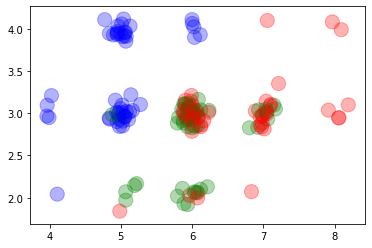

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Adding a little bit of noise so that it's easier to visualize
data_with_noise = data.iloc[:, :2] + np.random.normal(loc=0, scale=0.1, size=(150, 2))
#data_with_noise = data
plt.scatter(data_with_noise.length, data_with_noise.width, c=[ "bgr"[k] for k in data.iloc[:,2] ], s=200, alpha=0.3)

在该图中，我们可以轻松地看到蓝点集中在左上角，绿色点集中在左下角，红色点集中在右上角。

现在，让我们尝试在此数据上训练决策树。

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['length', 'width']].values, data.type.values, test_size=0.2)

classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(X_train, y_train)
classifier.predict(X_test)

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 2, 0, 1])

In [49]:
classifier.score(X_test, y_test)

0.7

因此，在这种情况下，我们的分类精度为70％。

现在，使用概率模型继续我们的第二种方法。 完成此分类任务的最明显方法是对所有这些变量计算联合概率分布，然后根据我们的新数据点对这些变量进行边际化和约化以获得类的概率。

In [50]:
X_train, X_test = data[:120], data[120:]

In [51]:
X_train

,length,width,type
50,7,3,1
74,6,3,1
29,5,3,0
66,6,3,1
82,6,3,1
...,...,...,...
140,7,3,2
117,8,4,2
118,8,3,2
3,5,3,0


In [52]:
# Computing the joint probability distribution over the training data
joint_prob = X_train.groupby(['length', 'width', 'type']).size() / 120
joint_prob

length  width  type
4       2      0       0.008333
        3      0       0.033333
5       2      1       0.025000
               2       0.008333
        3      0       0.141667
               1       0.008333
        4      0       0.133333
6       2      1       0.066667
               2       0.016667
        3      1       0.200000
               2       0.133333
        4      0       0.033333
7       2      2       0.008333
        3      1       0.058333
               2       0.075000
        4      2       0.008333
8       3      2       0.033333
        4      2       0.008333
dtype: float64

In [53]:
# Predicting values

# Selecting just the feature variables.
X_test_features = X_test.iloc[:, :2].values
X_test_actual_results = X_test.iloc[:, 2].values

predicted_values = []
for i in X_test_features:
    predicted_values.append(joint_prob[i[0], i[1]].idxmax())
    
predicted_values = np.array(predicted_values)
predicted_values

array([0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 2, 2, 0, 2, 1, 0, 2], dtype=int64)

In [54]:
# Comparing results with the actual data.
predicted_values == X_test_actual_results

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False, False, False, False,  True,  True,  True, False,
       False,  True,  True])

In [55]:
score = (predicted_values == X_test_actual_results).sum() / 30
print(score)

0.6333333333333333


### 为什么要使用概率图形模型

在前面的示例中，我们了解了贝叶斯推理的工作原理。 我们根据数据构造一个联合分布，然后根据观察到的变量来计算后验分布。 然后，我们查询此后验分布以预测新数据点的值。

但是这种方法的问题是联合概率分布与每个变量的状态数（基数）成指数关系。 因此，对于具有很多特征或特征基数高的问题，由于计算限制，推理成为一项困难的任务。 例如，对于每个具有10个状态的10个随机变量，联合分布的大小将为10^10。

__概率图形模型（PGM）__：PGM是一种通过利用变量之间的（条件）独立性来紧凑地表示随机变量上的联合概率分布的技术。 PGM还为我们提供了有效地对这些联合分布进行推断的方法。

每个图形模型的特征是图形结构（可以是有向的，无向的或两者都有）和与每个图形关联的一组参数。

可以使用贝叶斯模型（一种图形模型）将上述示例中的问题表示为：

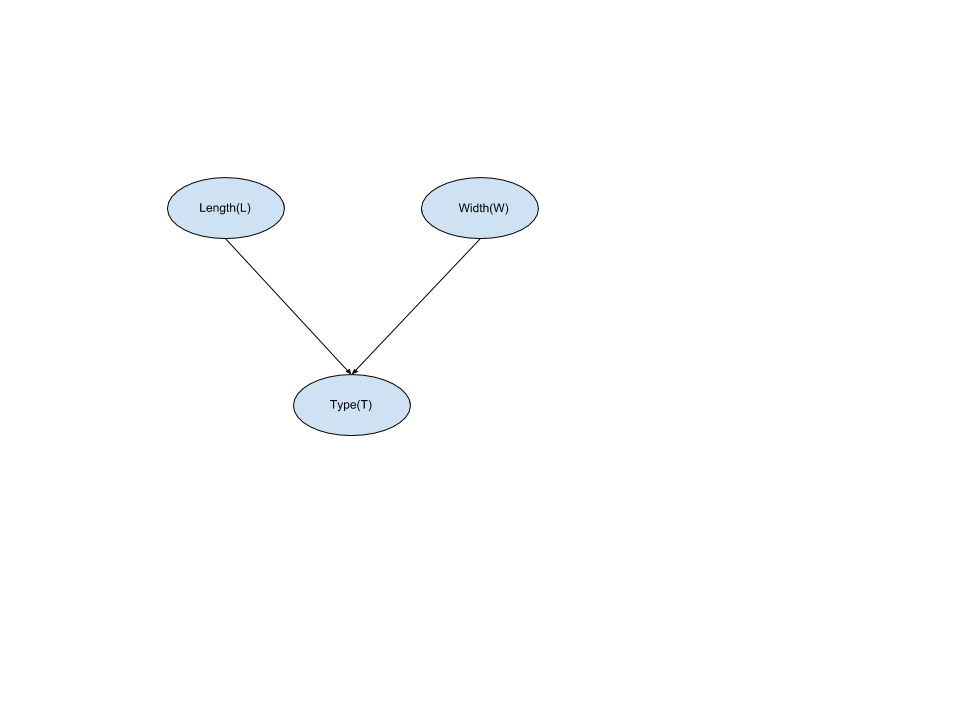

In [23]:
Image(filename='./images/1/Iris_BN.png')

在这种情况下，网络的参数将是$P(L)$，$ P(W)$和$P(T|L,W)$。 因此，我们将需要为$ L $存储5个值，为$ W $存储3个值，为$ P(T|L,W)$存储45个值。 因此，总共需要45 + 5 + 3 = 53个值来完全对网络进行参数化，实际上这是我们需要$P(T,L,W)$的45个以上的值。 但是在较大的网络中，图形模型有助于节省空间。 我们可以以如下所示的学生网络为例：

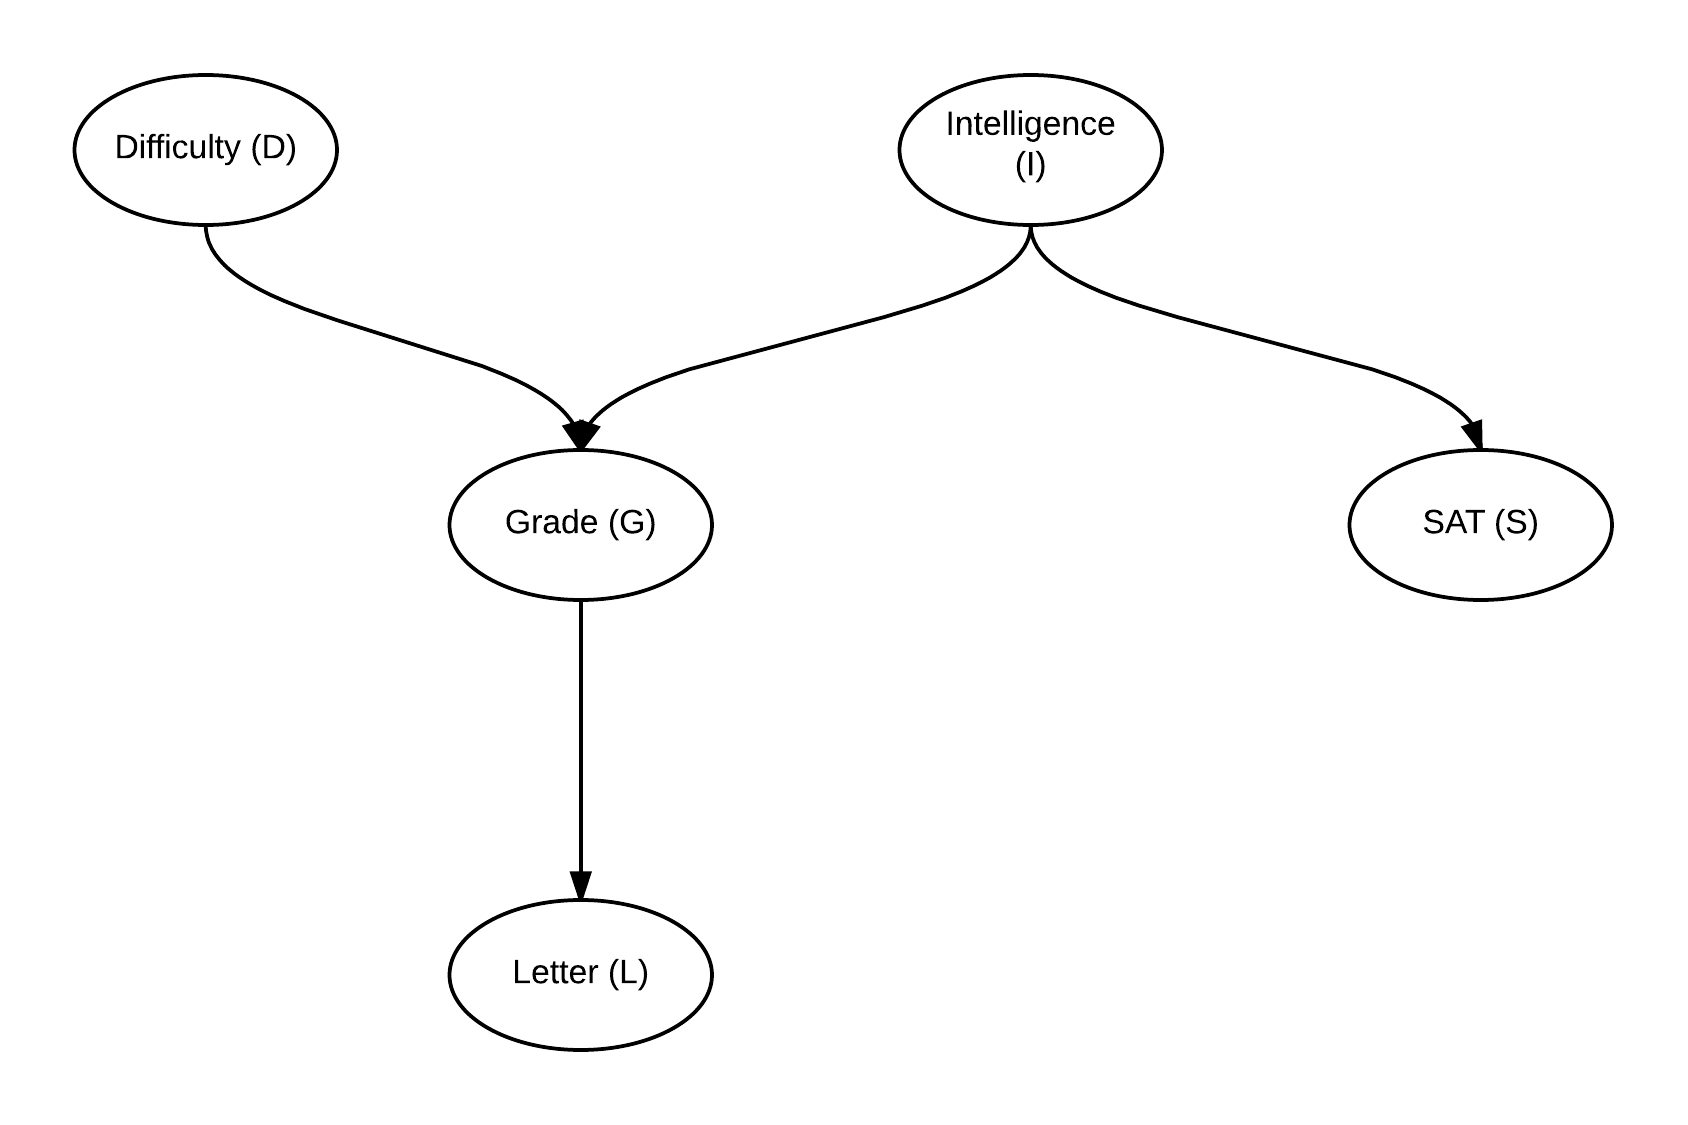

In [24]:
Image(filename='./images/1/student.png')

考虑到$ D $的基数为2，$ I $的基数为2，$ S $的基数为2，$ G $的基数为3，$ L $的基数为2。 $ P(D)$，$ P(I)$，$ P(S|I)$，$ P(G|D,I)$，$P(L|G)$。 因此，所需的值数将是：$ 2 $ for $ P(D)$，$ 2 $ for $ P(I)$，$ 12 $ for $ P(G|D，I）$，$ 6 $ for $ P(L|G)$，$P(S|I)$的$ 4 $，总计$ 4 + 6 + 12 + 2 + 2 = 26 $，而所有变量的联合分配需要 $ 2 * 2 * 3 * 2 * 2 = 48 $。

#### 图形模型的类型

主要有两种类型的图形模型：
1.贝叶斯模型：贝叶斯模型由有向图和与每个节点关联的条件概率分布（CPD）组成。 每个CPD的格式为$P(节点|父节点(节点))$，其中$ parent(节点)$是图结构中节点的父节点。
2.马尔可夫模型：马尔可夫模型由无向图组成，并由“因子”参数化。 因子表示两个或多个变量彼此一致。

### 2.什么是贝叶斯模型
贝叶斯网络，贝叶斯网络，信念网络，贝叶斯（Bayes）模型或概率有向非循环图形模型是概率图形模型（一种统计模型），它通过有向无环图表示一组随机变量及其条件相关性（ DAG）。 当我们要表示随机变量之间的因果关系时，通常使用贝叶斯网络。 使用条件概率分布（CPD）对贝叶斯网络进行参数化。 使用$P(node| Pa(node))$参数化网络中的每个节点，其中$Pa(node)$代表网络中节点的父节点。

我们可以以学生模型为例：

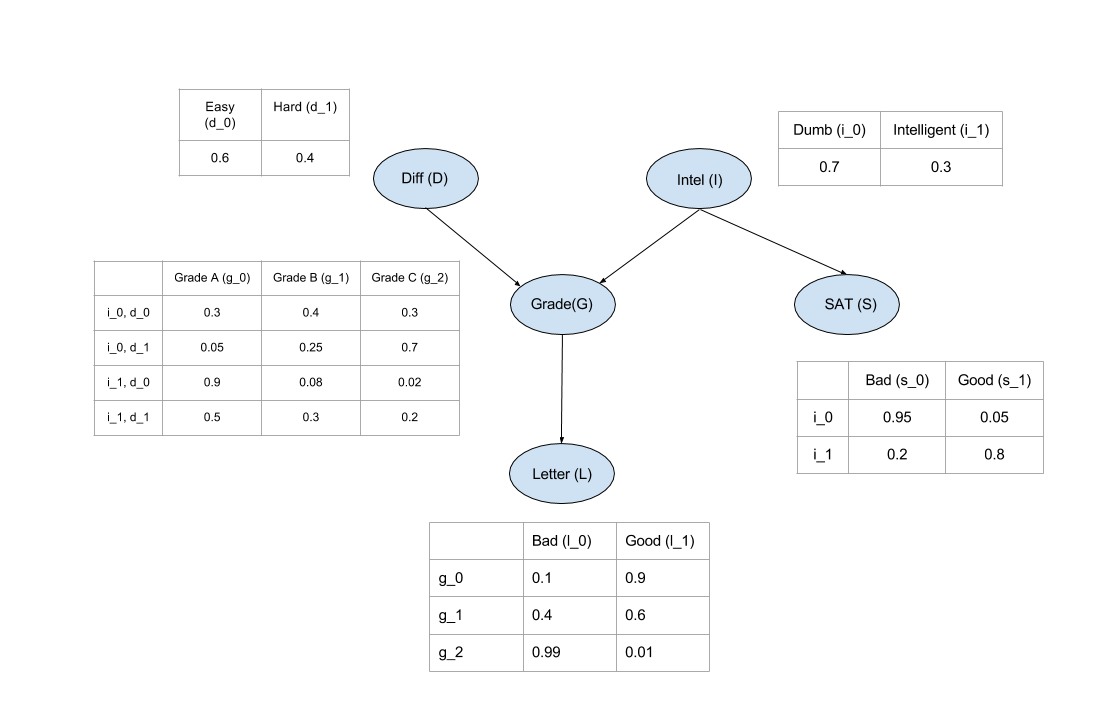

In [25]:
Image('./images/2/student_full_param.png')

在pgmpy中，我们分别定义网络结构和CPD，然后将它们与该结构相关联。 这是定义上述模型的示例：

In [26]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

In [27]:
# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='L', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly 
# defined and sum to 1.
model.check_model()

True

In [28]:
# CPDs can also be defined using the state names of the variables. If the state names are not provided
# like in the previous example, pgmpy will automatically assign names as: 0, 1, 2, ....

cpd_d_sn = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['Easy', 'Hard']})
cpd_i_sn = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['Dumb', 'Intelligent']})
cpd_g_sn = TabularCPD(variable='G', variable_card=3, 
                      values=[[0.3, 0.05, 0.9,  0.5],
                              [0.4, 0.25, 0.08, 0.3],
                              [0.3, 0.7,  0.02, 0.2]],
                      evidence=['I', 'D'],
                      evidence_card=[2, 2],
                      state_names={'G': ['A', 'B', 'C'],
                                   'I': ['Dumb', 'Intelligent'],
                                   'D': ['Easy', 'Hard']})

cpd_l_sn = TabularCPD(variable='L', variable_card=2, 
                      values=[[0.1, 0.4, 0.99],
                              [0.9, 0.6, 0.01]],
                      evidence=['G'],
                      evidence_card=[3],
                      state_names={'L': ['Bad', 'Good'],
                                   'G': ['A', 'B', 'C']})

cpd_s_sn = TabularCPD(variable='S', variable_card=2,
                      values=[[0.95, 0.2],
                              [0.05, 0.8]],
                      evidence=['I'],
                      evidence_card=[2],
                      state_names={'S': ['Bad', 'Good'],
                                   'I': ['Dumb', 'Intelligent']})

# These defined CPDs can be added to the model. Since, the model already has CPDs associated to variables, it will
# show warning that pmgpy is now replacing those CPDs with the new ones.
model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)
model.check_model()

True

In [29]:
# We can now call some methods on the BayesianModel object.
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x2341a0ef288>,
 <TabularCPD representing P(I:2) at 0x2341a0ef248>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x2341a0ef4c8>,
 <TabularCPD representing P(L:2 | G:3) at 0x2341a0ef388>,
 <TabularCPD representing P(S:2 | I:2) at 0x2341a0ef5c8>]

In [30]:
# Printing a CPD which doesn't have state names defined.
print(cpd_g)

+------+------+------+------+------+
| I    | I(0) | I(0) | I(1) | I(1) |
+------+------+------+------+------+
| D    | D(0) | D(1) | D(0) | D(1) |
+------+------+------+------+------+
| G(0) | 0.3  | 0.05 | 0.9  | 0.5  |
+------+------+------+------+------+
| G(1) | 0.4  | 0.25 | 0.08 | 0.3  |
+------+------+------+------+------+
| G(2) | 0.3  | 0.7  | 0.02 | 0.2  |
+------+------+------+------+------+


In [31]:
# Printing a CPD with it's state names defined.
print(model.get_cpds('G'))

+------+---------+---------+----------------+----------------+
| I    | I(Dumb) | I(Dumb) | I(Intelligent) | I(Intelligent) |
+------+---------+---------+----------------+----------------+
| D    | D(Easy) | D(Hard) | D(Easy)        | D(Hard)        |
+------+---------+---------+----------------+----------------+
| G(A) | 0.3     | 0.05    | 0.9            | 0.5            |
+------+---------+---------+----------------+----------------+
| G(B) | 0.4     | 0.25    | 0.08           | 0.3            |
+------+---------+---------+----------------+----------------+
| G(C) | 0.3     | 0.7     | 0.02           | 0.2            |
+------+---------+---------+----------------+----------------+


In [33]:
model.get_cardinality('G')

3

### 2.贝叶斯网络中的独立性

贝叶斯网络的网络结构所隐含的独立性可以分为两种类型：
1. __局部独立性：__网络中的任何变量均独立于其父代的非后代。 数学上可以写成：$$(X \perp NonDesc(X)| Pa(X)$$
其中$ NonDesc(X)$是不是$ X $的后代的变量集，而$ Pa（X）$是$ X $的父代的变量集。

2. __全球独立性：__为了讨论贝叶斯网络中的全球独立性，我们需要研究各种可能的网络结构。
从2个节点开始，只有两种可能的连接方式：

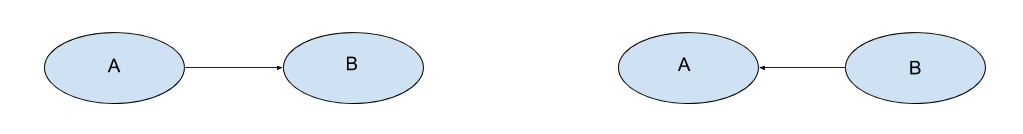

In [34]:
Image('./images/2/two_nodes.png')

在以上两种情况下，很明显，任何一个节点的更改都会影响另一个节点。 对于第一种情况，我们可以以$难度\rightarrow等级$为例。 如果我们增加了课程的难度，那么获得更高等级的可能性就会降低。 对于第二种情况，我们可以以$ SAT \leftarrow Intel $为例。 现在，如果我们增加在SAT考试中获得好成绩的可能性，这意味着学生很聪明，因此增加了$ i_1 $的可能性。 因此，在上述两种情况下，变量的任何变化都会导致另一个变量的变化。

现在，在3个节点之间有四种可能的连接方式：

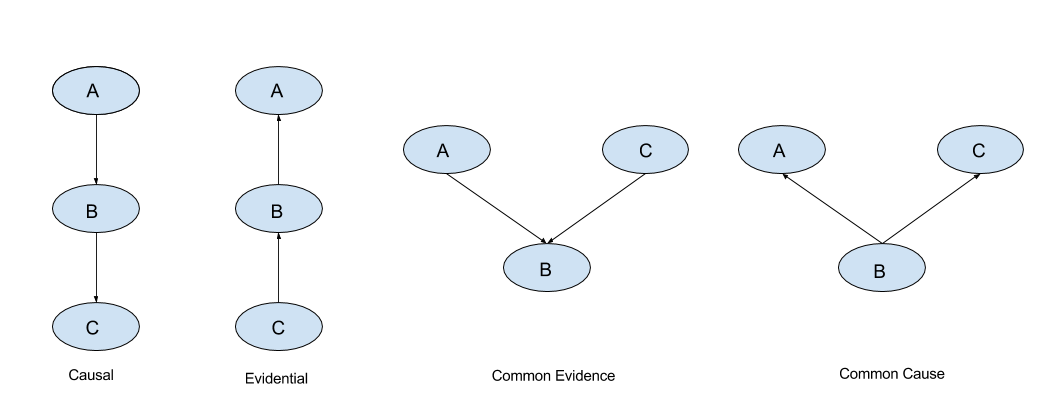

In [35]:
Image('./images/2/three_nodes.png')

现在，在上述情况下，我们将看到在各种情况下从$ A $到$ C $的影响流。

1. __原因__：在一般情况下，当我们对变量$ A $进行任何更改时，它将具有变量$ B $的作用（如上所述），而$ B $的更改将更改$ C$中的值。 。另一种可能的情况是观察到$ B $时，即我们知道$ B $的值。因此，在这种情况下，$ A $的任何更改都不会影响$ B $，因为我们已经知道该值。因此，$ C $不会有任何变化，因为它仅取决于$ B $。从数学上讲，我们可以说：$(A \perp C |B)$。
2. __证据：__同样，在这种情况下，也观察$ B $使$ C $独立于$ A $。否则，当未观察到$ B $时，影响力将从$ A $流向$ C $。因此，$(A \perp C | B)$。
3. __共同的证据__:这种情况与其他情况有些不同。当未观察到$ B $时，$ A $的任何变化都反映了$ B $的某些变化，但没有反映$ C $的变化。让我们以$ D \rightarrow G \leftarrow I $为例。在这种情况下，如果我们增加了课程的难度，那么获得更高分数的可能性就会降低，但这不会影响学生的智力。但是，当观察到$ B $时，我们假设该学生获得了良好的成绩。现在，如果我们增加课程难度，这将增加学生变得聪明的可能性，因为我们已经知道他的成绩很好。因此，在这种情况下，$(A \perp C)$和$(A \not \perp C|B)$。该结构也通常被称为V结构。
4. __共同原因：__当未观察到$ B $时，影响力从$ A $流向$ C $。但是，当观察到$ B $且$ A $的更改不会影响$ C $，因为它仅取决于$ B $。因此，这里也是$(A \perp C|B)$。

让我们不看看使用pgmpy在newtork中查找独立性的几个示例：

In [36]:
# Getting the local independencies of a variable.
model.local_independencies('G')

(G ⟂ S | D, I)

In [37]:
# Getting all the local independencies in the network.
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D ⟂ I, S)
(I ⟂ D)
(S ⟂ G, D, L | I)
(G ⟂ S | D, I)
(L ⟂ D, I, S | G)

In [38]:
# Active trail：对于网络中的任何两个变量A和B，如果A的任何变化都会影响B的值，那么我们说A和B之间存在活动路径。
# 在pgmpy中，active_trail_nodes给出了一组受参数传递的节点的任何变化影响（即相关）的节点。
model.active_trail_nodes('D')

{'D': {'D', 'G', 'L'}}

In [39]:
model.active_trail_nodes('D', observed='G')

{'D': {'D', 'I', 'S'}}

### 3.这个贝叶斯网络如何表示变量的联合分布？
到现在为止，我们一直在考虑贝叶斯网络可以表示联合分布而没有任何证据。 现在，让我们看看如何从贝叶斯网络中计算联合分布。

根据概率的链式规则，我们知道：
$$ P(A,B)= P(A|B)* P(B)$$

现在在这种情况下：
$$ P(D,I,G,L,S)= P(L|S,G,D,I)* P(S|G,D,I)* P(G|D,I)* P(D|I)* P(I)$$

将本地独立性条件应用到上面的方程中，我们将得到：
$$ P(D,I,G,L,S)= P(L|G)* P(S|I)* P(G|D,I)* P(D)* P(I)$$

从上面的方程式中，我们可以清楚地看到，所有变量的联合分布只是网络中所有CPD的乘积。 因此，以图形结构对联合分布中的独立性进行编码有助于我们减少了需要存储的参数数量。

### 4.贝叶斯模型中的推论
到目前为止，我们仅讨论了代表贝叶斯网络的问题。现在，让我们看看如何在贝叶斯模型中进行推理，并使用它来预测用于机器学习任务的新数据点上的值。在本节中，我们将考虑已经有我们的模型。在本教程的后面部分中，我们将讨论从数据构造模型。

在推论中，我们尝试在给定其他变量的情况下通过网络回答概率查询。因此，鉴于他在SAT上的得分很高，我们可能想知道一个困难学生的聪明成绩。因此，为了从联合分布计算这些值，我们将必须减少给定变量$ I = 1 $，$ D = 1 $，$ S = 1 $，然后对其他变量$ L $进行边际化以得到$ P(G | I = 1,D = 1,S = 1)$。
但是对整个联合分布进行边际化和归约运算在计算上是昂贵的，因为我们需要为每个运算迭代整个表，并且表是变量数量的指数。但是在图形模型中，我们利用独立性将这些操作分解为较小的部分，从而使其速度更快。

图形模型中非常基本的推理方法之一是“变量消除(Variable Elimination)”。

#### 变量消除
我们知道：

$ P(D,I,G,L,S)= P(L|G)* P(S|I)* P(G|D,I)* P(D)* P(I)$

现在假设我们只想计算G的概率。为此，我们将需要对所有其他变量进行边际化。

$ P(G)= \sum_ {D,I,L,S} P(D,I,G,L,S)$
$ P(G)= \sum_ {D,I,L,S} P(L|G)* P(S|I)* P(G|D,I)* P(D)* P(I)$
$ P(G)= \sum_D \sum_I \sum_L \sum_S P(L|G)* P(S|I)* P(G|D,I)* P(D)* P(I)$

现在，由于并非所有条件分布都依赖于所有变量，因此我们可以将求和运算推入内部：

$ P(G)= \sum_D \sum_I \sum_L \sum_S P(L|G)* P(S|I)* P(G|D,I)* P(D)* P(I)$
$ P(G)= \sum_D P(D)\sum_I P(G|D,I)* P(I)\sum_S P(S|I)\sum_L P(L|G)$

因此，通过将求和运算推入内部，我们节省了很多计算时间，因为我们现在必须遍历较小的表。

让我们以在pgmpy中使用Variable Elimination进行推理的示例为例：

In [40]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
g_dist = infer.query(['G'])
print(g_dist)

Eliminating: I: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 999.83it/s]

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.3620 |
+------+----------+
| G(B) |   0.2884 |
+------+----------+
| G(C) |   0.3496 |
+------+----------+


在某些情况下，我们想计算条件分布，例如$ P（G | D = 0，I = 1）$。 在这种情况下，我们需要对方程进行一些修改：

$ P(G|D = 0,I = 1)= \sum_L \sum_S P(L|G)* P(S|I = 1)* P(G | D = 0,I = 1)* P(D = 0)* P(I = 1)$
$ P(G|D = 0,I = 1)= P(D = 0)* P(I = 1)* P(G|D = 0,I = 1)* \sum_L P(L|G)* \sum_S P(S | I = 1)$

在pgmpy中，在条件分布的情况下，我们只需要传递一个额外的参数即可：

In [41]:
print(infer.query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'}))

Eliminating: S: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1996.81it/s]

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.9000 |
+------+----------+
| G(B) |   0.0800 |
+------+----------+
| G(C) |   0.0200 |
+------+----------+


#### 从新数据点预测值
从新数据点预测值与计算条件概率非常相似。 给定所有其他功能，我们需要查询我们需要预测的变量。 唯一的区别是，我们不是获取概率分布，而是对获取变量的最可能状态感兴趣。

在pgmpy中，这称为MAP查询。 这是一个例子：

In [42]:
infer.map_query(['G'])

Eliminating: I: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1333.85it/s]


{'G': 'A'}

In [43]:
infer.map_query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'})

Eliminating: S: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1032.06it/s]


{'G': 'A'}

In [44]:
infer.map_query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent', 'L': 'Good', 'S': 'Good'})

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


{'G': 'A'}

### 5.其他推论方法
即使像变量消除之类的精确推理算法优化了推理任务，但在大型模型的情况下，它在计算上仍然非常昂贵。 对于这种情况，我们可以使用近似算法，例如消息传递算法，采样算法等。

### 具体案例

数据集：超重乳腺癌幸存者的参加者信息

目标：模拟健康行为和习惯之间的相互关系，得出贝叶斯网络

数据集包含以下变量：

- PraticipantNumber：编号
- TumorStage：参与者的病历，包括肿瘤特征
- Neighborhood：邻里环境指数（Neighborhood）用于衡量步行能力。它的范围从0到6，得分越高表示附近的步行环境越好
- Alochol：每月酒精摄入量
- Smoke：抽烟，具有“是”或“否”的两个级别因子
- Insomnia：失眠-具有“是”或“否”的两个因素
- Depression：抑郁-两级因素，是或否
- Education：教育-教育场所（在分析中不使用）
- Sleep1：睡眠1-指睡眠障碍。规范为50，标准差为10。较高的分数表示睡眠质量较差
- Sleep2：睡眠2-睡眠障碍。取平均值为50，标准差为10。
- QOLp：生活质量（物理）。使用SF-36标尺，范围是0-100。分数越高，生活方式越好。
- QOLm：生活质量（心理）。使用SF-36比例尺，范围是0-100。分数越高，生活方式越好。
- Arthritis：关节炎-具有“是”或“否”的两个因素
- Insulin：　胰岛素-范围从5-8 U / ml
- CRP：C反应蛋白。范围12-16
- Age：年龄-介于0-120之间
- PA：PA是每天每分钟总计数的平均值（全天），因此代表了捕获活动总量的量度
- BMI-体重指数（kg / m ^ 2）

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
import networkx as nx

In [3]:
data = pd.read_csv('./dataset.csv')
data.head()

,ParticipantNumber,TumorStage,Neighborhood,Alcohol,Smoke,Insomnia,Depression,Education,Sleep1,Sleep2,QOLp,QOLm,Arthritis,Insulin,CRP,PA,BMI,Age
0,1,Stage 2,4,8.25,No,No,No,Postgraduate school or degree,44.2,38.7,86.875,93.250000,No,6.620323,14.662970,248.645687,29.387755,53
1,2,Stage 1,1,17.00,No,No,Yes,"Some college, technical school or Associate D...",51.2,43.6,76.250,81.625000,Yes,6.588302,15.086824,241.912148,28.398718,67
2,3,Stage 1,2,25.50,No,No,No,Postgraduate school or degree,35.9,38.7,58.750,79.625000,No,5.773663,16.045979,408.521245,20.077335,54
3,4,Stage 3,3,0.00,No,No,Yes,"Some college, technical school or Associate D...",56.3,52.9,26.875,37.958333,No,6.898928,16.312136,177.601267,26.838648,66
4,5,Stage 2,4,10.25,Yes,Yes,Yes,"Some college, technical school or Associate D...",62.6,56.1,76.250,82.250000,Yes,5.349781,12.376667,142.443154,37.165193,50


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 18 columns):
ParticipantNumber    303 non-null int64
TumorStage           303 non-null object
Neighborhood         303 non-null int64
Alcohol              303 non-null float64
Smoke                303 non-null object
Insomnia             303 non-null object
Depression           303 non-null object
Education            303 non-null object
Sleep1               303 non-null float64
Sleep2               303 non-null float64
QOLp                 303 non-null float64
QOLm                 303 non-null float64
Arthritis            303 non-null object
Insulin              303 non-null float64
CRP                  303 non-null float64
PA                   303 non-null float64
BMI                  303 non-null float64
Age                  303 non-null int64
dtypes: float64(9), int64(3), object(6)
memory usage: 42.7+ KB


In [58]:
data.replace({'Yes':1,'No':0}, inplace=True)
data.head()

,ParticipantNumber,TumorStage,Neighborhood,Alcohol,Smoke,Insomnia,Depression,Education,Sleep1,Sleep2,QOLp,QOLm,Arthritis,Insulin,CRP,PA,BMI,Age
0,1,Stage 2,4,8.25,0,0,0,Postgraduate school or degree,44.2,38.7,86.875,93.250000,0,6.620323,14.662970,248.645687,29.387755,53
1,2,Stage 1,1,17.00,0,0,1,"Some college, technical school or Associate D...",51.2,43.6,76.250,81.625000,1,6.588302,15.086824,241.912148,28.398718,67
2,3,Stage 1,2,25.50,0,0,0,Postgraduate school or degree,35.9,38.7,58.750,79.625000,0,5.773663,16.045979,408.521245,20.077335,54
3,4,Stage 3,3,0.00,0,0,1,"Some college, technical school or Associate D...",56.3,52.9,26.875,37.958333,0,6.898928,16.312136,177.601267,26.838648,66
4,5,Stage 2,4,10.25,1,1,1,"Some college, technical school or Associate D...",62.6,56.1,76.250,82.250000,1,5.349781,12.376667,142.443154,37.165193,50


## Bayesian Network

In [59]:
#定义贝叶斯模型
model=BayesianModel([('Arthritis','QOLp'), ('Arthritis','BMI'), ('BMI','CRP'),('BMI','Insulin'),('BMI','QOLp'),('Smoke','BMI'),('Insulin','PA'),('Sleep2','PA'),('Sleep2','QOLm'),('Sleep2','QOLp'),('Depression','Arthritis'),('Depression','Sleep2'),('Depression','QOLm'),('Depression','Sleep1'),('Insomnia','Depression'),('Insomnia','Sleep1')])
#采用最大似然法进行参数估计
model.fit(data, estimator=MaximumLikelihoodEstimator)
#model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")

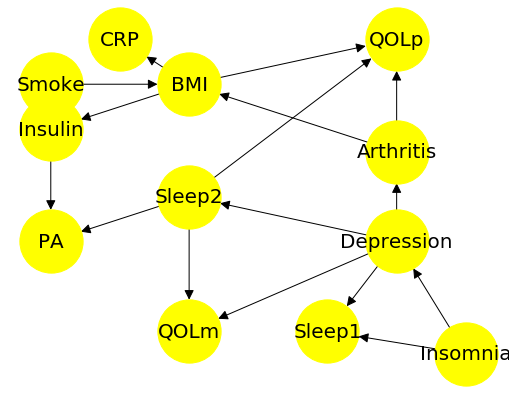

In [60]:
#画出贝叶斯网络图
fig, ax=plt.subplots(figsize=(9,7))
positions={'PA':(2,1),'Sleep2':(3,2),'QOLm':(3,-1),'Sleep1':(4,-1),'Insomnia':(5,-1.5),'Depression':(4.5,1),'Arthritis':(4.5,3),'Sleep2':(3,2),'BMI':(3,4.5) ,'CRP':(2.5,5.5),'Smoke':(2,4.5),'Insulin':(2,3.5),'QOLp':(4.5,5.5)}
nx.draw(model, pos=positions, with_labels=True, node_size=4000, font_size=20, arrowsize=20, node_color='yellow', ax=ax)

<p style =“ font-family：Times New Roman; font-size：15px”>第一个显著发现是以下变量没有（或存在）边缘：tumor stage, years from diagnosis to study entry, neighborhood, education, alcohol intake and coping style (MB scale)，表明这些变量（几乎）独立于所有其他因素。</ p>

<p style =“ font-family：Times New Roman; font-size：15px”>由于某些原因，对该网络的“Age年龄”绘图花费了太多时间，因此我跳过了该节点。 实际上应该与PA连接。</ p>

In [61]:
model.check_model()

True

In [62]:
model.get_cpds()

[<TabularCPD representing P(Arthritis:2 | Depression:2) at 0x2aaf44bd148>,
 <TabularCPD representing P(BMI:262 | Arthritis:2, Smoke:2) at 0x2aaf44c5208>,
 <TabularCPD representing P(CRP:303 | BMI:262) at 0x2aaf54ec088>,
 <TabularCPD representing P(Depression:2 | Insomnia:2) at 0x2aaf54e9d88>,
 <TabularCPD representing P(Insomnia:2) at 0x2aaf54e2448>,
 <TabularCPD representing P(Insulin:303 | BMI:262) at 0x2aaf54fce88>,
 <TabularCPD representing P(PA:303 | Insulin:303, Sleep2:26) at 0x2aaf5508088>,
 <TabularCPD representing P(QOLm:214 | Depression:2, Sleep2:26) at 0x2aaf5503e48>,
 <TabularCPD representing P(QOLp:96 | Arthritis:2, BMI:262, Sleep2:26) at 0x2aaf5d48a48>,
 <TabularCPD representing P(Sleep1:32 | Depression:2, Insomnia:2) at 0x2aaf5d48488>,
 <TabularCPD representing P(Sleep2:26 | Depression:2) at 0x2aaf5d48bc8>,
 <TabularCPD representing P(Smoke:2) at 0x2aaf5d48c48>]

## CPD

In [63]:
print(model.get_cpds('Smoke'))
print(model.get_cpds('Insomnia'))
print(model.get_cpds('Depression'))
print(model.get_cpds('Sleep2'))

+----------+----------+
| Smoke(0) | 0.531353 |
+----------+----------+
| Smoke(1) | 0.468647 |
+----------+----------+
+-------------+----------+
| Insomnia(0) | 0.706271 |
+-------------+----------+
| Insomnia(1) | 0.293729 |
+-------------+----------+
+---------------+--------------------+--------------------+
| Insomnia      | Insomnia(0)        | Insomnia(1)        |
+---------------+--------------------+--------------------+
| Depression(0) | 0.6588785046728972 | 0.4157303370786517 |
+---------------+--------------------+--------------------+
| Depression(1) | 0.3411214953271028 | 0.5842696629213483 |
+---------------+--------------------+--------------------+
+--------------+-----------------------+---------------+
| Depression   | Depression(0)         | Depression(1) |
+--------------+-----------------------+---------------+
| Sleep2(30.0) | 0.10112359550561797   | 0.032         |
+--------------+-----------------------+---------------+
| Sleep2(35.1) | 0.1404494382022472    |

## Inferences

In [64]:
inference = VariableElimination(model)

问题1：鉴于患者可以从失眠中幸存下来，是否会出现“抑郁症”？

In [65]:
query1= inference.map_query(variables=['Depression'], evidence={'Insomnia': 1})
print(query1)

Eliminating: Sleep1: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.17it/s]

{'Depression': 1}


问题2：考虑到患有关节炎和吸烟的人，BMI的可能值是多少？

In [45]:
query2= inference.map_query(variables=['BMI'], evidence={'Arthritis': 1,'Smoke' : 1})
print(query2)

Eliminating: Insulin: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.75it/s]

{'BMI': 28.515625}


问题3：如果我们将生活质量（身心健康）视为重要因素，那么一个人的睡眠习惯是什么？

In [46]:
query3= inference.map_query(variables=['Sleep1'], evidence={'QOLp': 30,'QOLm' : 30})
print(query3)
#Higher scores indicate worse sleep 

D:\Anaconda3\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: Insomnia: 100%|████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.16it/s]

{'Sleep1': 47.9}


问题4： 睡眠不足和胰岛素水平升高对身体活动有什么影响？

In [47]:
query4 = inference.map_query(variables=['PA'], evidence={'Insulin': 6, 'Depression':1})
print(query4)

Eliminating: Arthritis: 100%|███████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 112.50it/s]

{'PA': 462.3070267}


In [48]:
data = {'Query1': [[key for key in query1.keys()][0], [value for value in query1.values()][0]],
        'Query2': [[key for key in query2.keys()][0], [value for value in query2.values()][0]],
        'Query3': [[key for key in query3.keys()][0], [value for value in query3.values()][0]],
        'Query4': [[key for key in query4.keys()][0], [value for value in query4.values()][0]]}

result = pd.DataFrame(data)
result.to_csv('output.csv', index=False)
result

,Query1,Query2,Query3,Query4
0,Depression,BMI,Sleep1,PA
1,1,28.5156,47.9,462.307


## 推论

<ol>
<li>该人如果失眠，将患有抑郁症。</ li>
<li>如果BMI在25-29之间，则该人超重，这会导致乳腺癌的其他一些损害</ li>
<li>如果生活方式导致睡眠问题会导致较高的睡眠评分，则质量较低。
<li> BMI与胰岛素有很强的正相关性，因此BMI与体力活动成反比</ li>
</ ol>

### 贝叶斯网络预测



In [5]:
data = pd.read_csv('dataset.csv')
data.drop(['Education','ParticipantNumber','TumorStage','Neighborhood','Alcohol','Age'], axis=1, inplace=True)
data.replace({'Yes':1,'No':0}, inplace=True)
print(data)

     Smoke  Insomnia  Depression  Sleep1  Sleep2    QOLp       QOLm  \
0        0         0           0    44.2    38.7  86.875  93.250000   
1        0         0           1    51.2    43.6  76.250  81.625000   
2        0         0           0    35.9    38.7  58.750  79.625000   
3        0         0           1    56.3    52.9  26.875  37.958333   
4        1         1           1    62.6    56.1  76.250  82.250000   
..     ...       ...         ...     ...     ...     ...        ...   
298      0         1           1    54.3    54.0  68.750  50.583333   
299      1         0           0    42.9    35.1  85.000  87.375000   
300      0         0           0    28.9    38.7  85.625  78.500000   
301      1         1           1    61.5    55.1  67.500  53.208333   
302      1         0           1    38.0    41.4  65.625  84.750000   

     Arthritis   Insulin        CRP          PA        BMI  
0            0  6.620323  14.662970  248.645687  29.387755  
1            1  6.588302 

In [6]:
model=BayesianModel([('Arthritis','QOLp'), ('Arthritis','BMI'), ('BMI','CRP'),('BMI','Insulin'),('BMI','QOLp'),('Smoke','BMI'),('Insulin','PA'),('Sleep2','PA'),('Sleep2','QOLm'),('Sleep2','QOLp'),('Depression','Arthritis'),('Depression','Sleep2'),('Depression','QOLm'),('Depression','Sleep1'),('Insomnia','Depression'),('Insomnia','Sleep1')])
model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5


In [17]:
# 数据集划分为训练集和测试集

train_data = data[:250].copy()
predict_data= data[250:].copy()

In [19]:
model=BayesianModel([('Arthritis','QOLp'), ('Arthritis','BMI'), ('BMI','CRP'),('BMI','Insulin'),('BMI','QOLp'),('Smoke','BMI'),('Insulin','PA'),('Sleep2','PA'),('Sleep2','QOLm'),('Sleep2','QOLp'),('Depression','Arthritis'),('Depression','Sleep2'),('Depression','QOLm'),('Depression','Sleep1'),('Insomnia','Depression'),('Insomnia','Sleep1')])

model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5

In [20]:
predict_data.drop(['Depression'], axis=1, inplace=True)

pred = model.predict(predict_data)
pred

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 20.00it/s]


,Depression
0,0
1,0
2,1
3,0
4,0
5,0
6,1
7,0
8,1
9,0


In [21]:
pred_prob = model.predict_probability(predict_data)
pred_prob

,Depression_0,Depression_1
250,0.999989,0.000011
251,0.999501,0.000499
252,0.000467,0.999533
253,0.999790,0.000210
254,0.999311,0.000689
255,0.999879,0.000121
256,0.000020,0.999980
257,0.999749,0.000251
258,0.000040,0.999960
259,0.999514,0.000486


In [22]:
pred = pred.to_numpy()
predict_data = data[250:].to_numpy()

In [23]:
Depression=0


for i in range(0,len(pred)):
    if pred[i][0] == predict_data[i][1]:
        Depression += 1
    

Depression = (Depression/len(predict_data))*100


print("Accuracy of predicting Depression : ", round(Depression,2), "%")

Accuracy of predicting Depression :  73.58 %
